<a href="https://colab.research.google.com/github/yasminghd/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S3_4_Wildfire_Risk_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In week 3's final notebook, we will train classifiers on real [wildfire](https://en.wikipedia.org/wiki/Wildfire) data to map the fire risk in different regions of Italy. To keep the data size manageable, we will focus on the coastal [Liguria region](https://en.wikipedia.org/wiki/Liguria) that experiences a lot of wildfires, especially during the winter. 



---



**Credits**

This online tutorial would not be possible without invaluable contributions from [Andrea Trucchia](https://www.researchgate.net/profile/Andrea-Trucchia) (reduced data, methods), [Giorgio Meschi](https://www.linkedin.com/in/giorgio-meschi-86216b180/) (code, methods), and [Marj Tonini](https://www.researchgate.net/profile/Marj-Tonini-2) (presentation, methods). The methodology builds upon the following article:

[Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D., Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level, *Fire*, (2022)](https://www.mdpi.com/2571-6255/5/1/30) 

which generalizes the study below from the Liguria region (our case study) to all of Italy:

[Tonini, Marj, et al. "A machine learning-based approach for wildfire susceptibility mapping. The case study of the Liguria region in Italy." *Geosciences* 10.3 (2020): 105.](https://www.mdpi.com/2076-3263/10/3/105)



---



# Exercise 4: Mapping Wildfire Susceptibility in the Liguria Region with Simple Machine Learning Classifiers

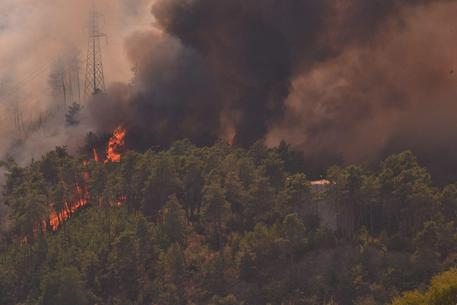

**Caption**: A wildfire in Italy. Can we predict which locations are most susceptible to wildfires using simple classifiers? 🔥

**Source**: [ANSA](https://www.ansa.it/english/news/2015/08/14/wildfires-in-italy-up-120-this-summer-on-past-two-years_f6e4eff7-ac07-4f9e-aa5a-e61f8c2ad7f2.html)

Let's start by downloading and loading the datasets into memory using the [`pooch`](https://pypi.org/project/pooch/), [`pickle5`](https://pypi.org/project/pickle5/), and [`GeoPandas`](https://geopandas.org/en/stable/) libraries:

In [53]:
# Install geopandas and pickle5
%pip install geopandas
%pip install pickle5

In [54]:
import geopandas as gpd
import numpy as np
import pickle5 as pickle
import pooch

In [55]:
# Function to load the data
def load_data(path):
    
    # Load the content of the pickle file (using pickle5 for Google Colab)
    with open(path, "rb") as fh:
        points_df = pickle.load(fh)

    # Convert it to a Geopandas `GeoDataFrame` for spatial analysis
    points_df = gpd.GeoDataFrame(points_df, 
                                 geometry=gpd.points_from_xy(np.float64(points_df.x), 
                                                             np.float64(points_df.y))) 
    return points_df

In [56]:
# Path to the data in UNIL OneDrive
variables_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EU4FQkuYknFDiDfd7droyAcBP0qFOR5-c-_Oq74gjhTGwQ?download=1',
                            known_hash='e8ebc70f972b5af4ef3d6110dcd61ce01ce5a830dcdb7d2c9e737aeab781606c')
wildfires_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EcjqeERsnIRHjhcx1ZFVNggBS7nPUkW530XRrpVUB-qnOw?download=1',
                             known_hash='361f067aafbac8add8f8a9a5c630df3c962cd37a2f125f420e7b9330fd0a1a4c')

In [82]:
# Load the data and convert it to a GeoPandas `GeoDataFrame`
# This can take a minute
variables = load_data(variables_path)
wildfires = load_data(wildfires_path)

## Part I: Pre-Processing the Dataset for Classification

**Q1) After analyzing the topography and land cover data provided in `variables`, create your input dataset `inputs` from `variables` to predict the occurence of wildfires (`wildfires`). Keep at least one categorical variable (`veg`, `bioclim`, or `phytoclim`).**

Hint 1: Refer to the documentation [at this link](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/EREf92h-43VBtgPjwveMfrQBRahitmHxBKAtNx04lleh7Q?e=Fx6nad) to know what the different `keys` of `variables` refer to.

Hint 2: You may refer to Table 1 of [Tonini et al.](https://www.mdpi.com/2076-3263/10/3/105), copied below, to choose your input variables, although we recommend starting with less inputs at first to build a simpler model and avoid overfitting.

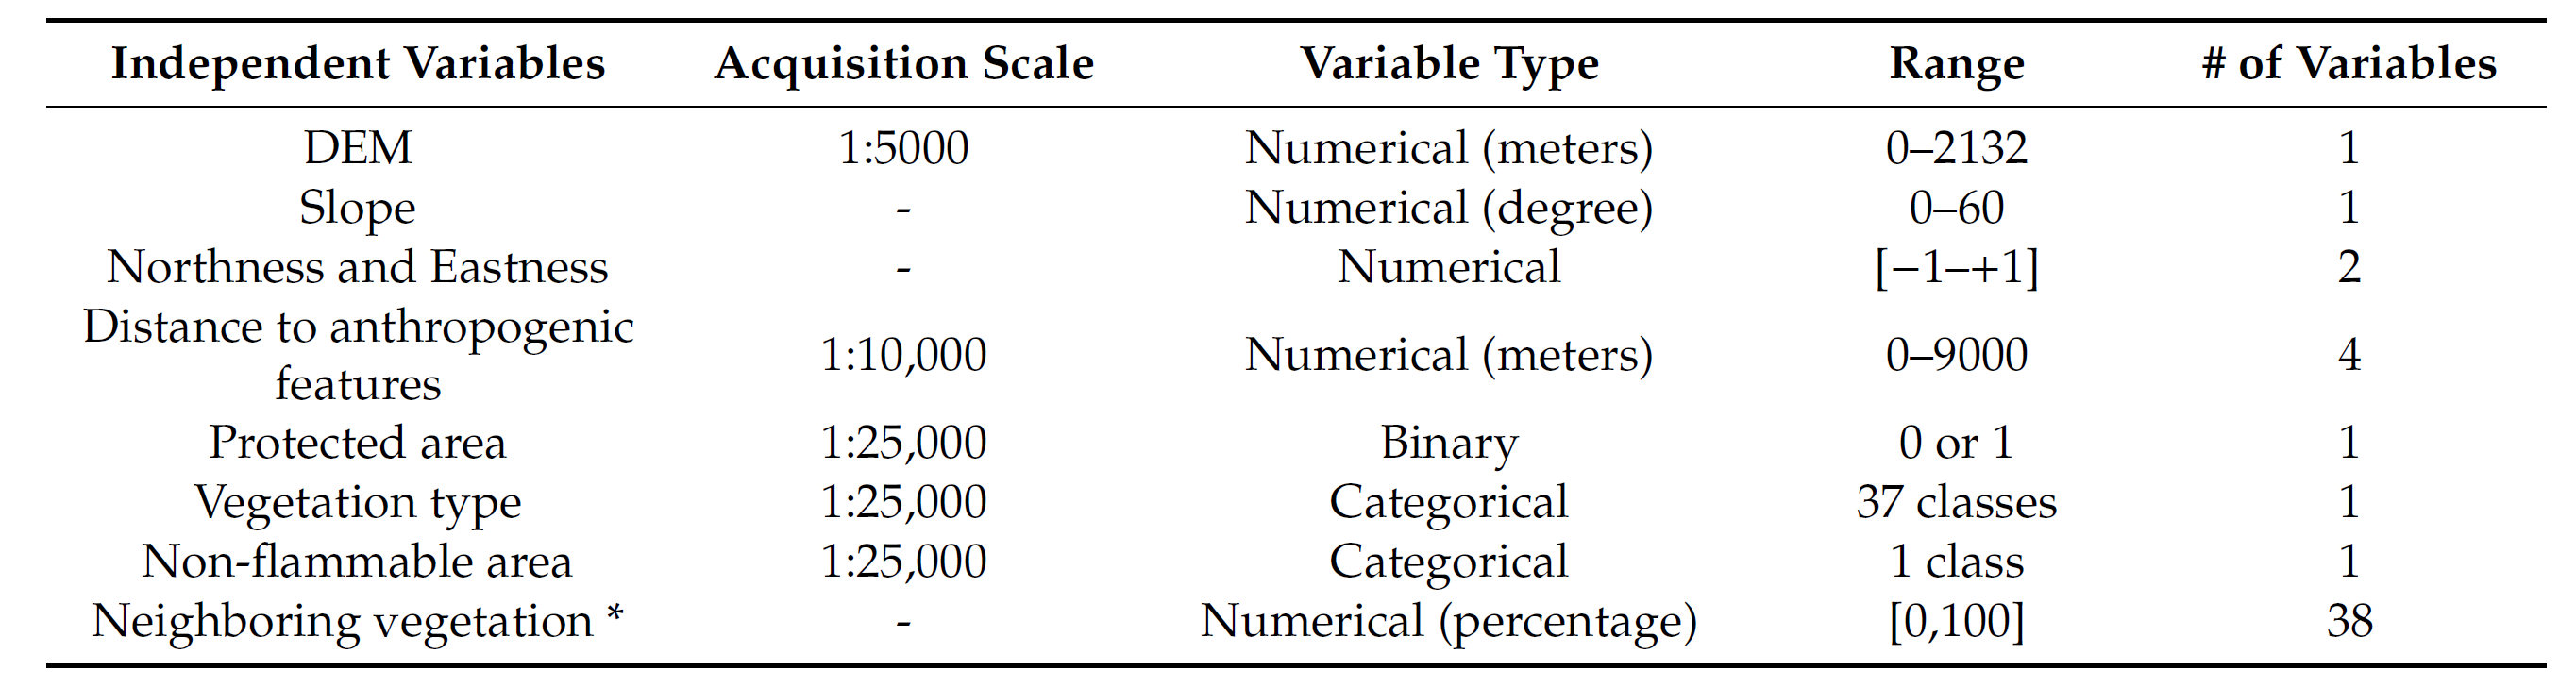

In [58]:
# Explore the `variables` dataset
print(variables)

             row   col             x             y  dem      slope     north  \
point_index                                                                    
0              1  1158  1.494904e+06  4.946934e+06  563  20.843185 -0.994807   
1              2  1156  1.494704e+06  4.946834e+06  527  23.599121 -0.978550   
2              2  1157  1.494804e+06  4.946834e+06  525  26.699856 -0.996631   
3              2  1158  1.494904e+06  4.946834e+06  519  24.512413 -0.997833   
4              2  1159  1.495004e+06  4.946834e+06  532  20.421495 -0.966900   
...          ...   ...           ...           ...  ...        ...       ...   
519336       980    40  1.383104e+06  4.849034e+06  125  29.669502 -0.822824   
519386       981    42  1.383304e+06  4.848934e+06  139  23.541714 -0.972621   
519388       981    44  1.383504e+06  4.848934e+06  113  16.290375 -0.372128   
519422       982    44  1.383504e+06  4.848834e+06   95  23.240271 -0.925640   
519423       982    45  1.383604e+06  4.

In [59]:
# Select the inputs you would like to keep
# I have decided to save the following inputs: DEM, slope, northness, eastness, distance o anthropogenic features, and vegetation type

In [60]:
# Form the `inputs` dataset
inputs = variables[['dem', 'slope', 'north', 'east', 'urban_d', 'veg']]
type(inputs)
inputs.head()
print(variables)

             row   col             x             y  dem      slope     north  \
point_index                                                                    
0              1  1158  1.494904e+06  4.946934e+06  563  20.843185 -0.994807   
1              2  1156  1.494704e+06  4.946834e+06  527  23.599121 -0.978550   
2              2  1157  1.494804e+06  4.946834e+06  525  26.699856 -0.996631   
3              2  1158  1.494904e+06  4.946834e+06  519  24.512413 -0.997833   
4              2  1159  1.495004e+06  4.946834e+06  532  20.421495 -0.966900   
...          ...   ...           ...           ...  ...        ...       ...   
519336       980    40  1.383104e+06  4.849034e+06  125  29.669502 -0.822824   
519386       981    42  1.383304e+06  4.848934e+06  139  23.541714 -0.972621   
519388       981    44  1.383504e+06  4.848934e+06  113  16.290375 -0.372128   
519422       982    44  1.383504e+06  4.848834e+06   95  23.240271 -0.925640   
519423       982    45  1.383604e+06  4.

**Q2) To avoid making inaccurate assumptions about which types of vegetation and non-flammable area are most similar, convert your categorical inputs into one-hot vectors.**

Hint 1: You may use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.fit_transform) method of `scikit-learn`'s [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class to convert categorical inputs into one-hot vectors.

Hint 2: Don't forget to remove the categorical variables from your input dataset, e.g. using [`drop`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) if you are still using a `GeoDataFrame`, or [`del`](https://docs.python.org/3/reference/simple_stmts.html#the-del-statement)/[`pop`](https://docs.python.org/3/library/stdtypes.html#dict.pop) if you are working with a Python dictionary. 

In [61]:
# Import the necessary classes and functions
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
import pandas as pd

In [62]:
enc = OneHotEncoder(handle_unknown='ignore')
veget = inputs['veg'].values.reshape(-1, 1)
#print(veget)
#print(type(veget))

In [63]:
con_veg =enc.fit_transform(veget)
#print(con_veg)
#print(type(con_veg))

In [64]:
# Convert your categorical inputs into one-hot vectors

new = pd.DataFrame(con_veg.toarray())

print(new)

new.columns = ['veg1', 'veg2', 'veg3', 'veg4', 'veg5', 'veg6', 'veg7']

#print(new)

print(type(new))
print(type(inputs))

#horizontal_stack = pd.concat([inputs, new], axis=1, ignore_index=True)

          0    1    2    3    4    5    6
0       0.0  0.0  0.0  0.0  0.0  1.0  0.0
1       0.0  0.0  0.0  0.0  0.0  1.0  0.0
2       0.0  0.0  0.0  0.0  0.0  1.0  0.0
3       0.0  0.0  0.0  0.0  0.0  1.0  0.0
4       0.0  0.0  0.0  0.0  0.0  1.0  0.0
...     ...  ...  ...  ...  ...  ...  ...
528664  0.0  0.0  0.0  0.0  0.0  0.0  1.0
528665  0.0  0.0  0.0  1.0  0.0  0.0  0.0
528666  0.0  0.0  0.0  1.0  0.0  0.0  0.0
528667  0.0  0.0  0.0  0.0  0.0  0.0  1.0
528668  0.0  0.0  0.0  1.0  0.0  0.0  0.0

[528669 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [65]:
# and to delete your categorical variables from your `inputs`
inputs.drop('veg', inplace=True, axis=1)
print(inputs)

             dem      slope     north      east     urban_d
point_index                                                
0            563  20.843185 -0.994807  0.101779  900.000000
1            527  23.599121 -0.978550  0.206010  824.621094
2            525  26.699856 -0.996631  0.082017  806.225769
3            519  24.512413 -0.997833 -0.065791  800.000000
4            532  20.421495 -0.966900 -0.255154  800.000000
...          ...        ...       ...       ...         ...
519336       125  29.669502 -0.822824 -0.568297    0.000000
519386       139  23.541714 -0.972621 -0.232396    0.000000
519388       113  16.290375 -0.372128  0.928181  100.000000
519422        95  23.240271 -0.925640  0.378406  100.000000
519423        67  15.023369 -0.884918  0.465746    0.000000

[528669 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
# Don't forget to add your one-hot vectors to your `inputs`
inputs = inputs.join(new)
print(inputs)

        dem      slope     north      east     urban_d  veg1  veg2  veg3  \
0       563  20.843185 -0.994807  0.101779  900.000000   0.0   0.0   0.0   
1       527  23.599121 -0.978550  0.206010  824.621094   0.0   0.0   0.0   
2       525  26.699856 -0.996631  0.082017  806.225769   0.0   0.0   0.0   
3       519  24.512413 -0.997833 -0.065791  800.000000   0.0   0.0   0.0   
4       532  20.421495 -0.966900 -0.255154  800.000000   0.0   0.0   0.0   
...     ...        ...       ...       ...         ...   ...   ...   ...   
519467   78  18.016613 -0.776349  0.630303    0.000000   0.0   1.0   0.0   
519468   48  22.538818 -0.475895  0.879502    0.000000   0.0   1.0   0.0   
519469   16   7.200756 -0.890435 -0.455111    0.000000   0.0   0.0   1.0   
519470   54  15.985183 -0.724346  0.689437    0.000000   0.0   1.0   0.0   
519471   38  15.006866 -0.638808  0.769366    0.000000   0.0   1.0   0.0   

        veg4  veg5  veg6  veg7  
0        0.0   0.0   1.0   0.0  
1        0.0   0.0   

Now that we built our `inputs` dataset, we are ready to build our `outputs` dataset!

**Q3) Using the `point_index` column of `wildfires` and `variables`, create your `outputs` dataset, containing 1 when there was a wildfire and 0 otherwise.**

Hint: Check that `inputs` and `outputs` have the same number of cases by looking at their `.shape[0]` attribute. 

In [67]:
# Initialize your `outputs` dataset using the `variables` dataset

index = inputs.index.values
print(wildfires)
d = np.zeros([index.shape[0], 1])
outputs = pd.DataFrame(d)
outputs.index = inputs.index

                                    geometry             x             y  \
point_index                                                                
1761         POINT (1500504.192 4943934.406)  1.500504e+06  4.943934e+06   
1851         POINT (1500504.192 4943834.406)  1.500504e+06  4.943834e+06   
2025         POINT (1499404.192 4943634.406)  1.499404e+06  4.943634e+06   
2110         POINT (1498304.192 4943534.406)  1.498304e+06  4.943534e+06   
2111         POINT (1498404.192 4943534.406)  1.498404e+06  4.943534e+06   
...                                      ...           ...           ...   
519336       POINT (1383104.192 4849034.406)  1.383104e+06  4.849034e+06   
519386       POINT (1383304.192 4848934.406)  1.383304e+06  4.848934e+06   
519388       POINT (1383504.192 4848934.406)  1.383504e+06  4.848934e+06   
519422       POINT (1383504.192 4848834.406)  1.383504e+06  4.848834e+06   
519423       POINT (1383604.192 4848834.406)  1.383604e+06  4.848834e+06   

           

In [68]:
index_wf = wildfires.index.values
print(index_wf)
print(index)


[  1761   1851   2025 ... 519388 519422 519423]
[     0      1      2 ... 519469 519470 519471]


81834

In [84]:
# Fill it with 0 and 1 using the `wildfire` dataset

for i in range (0, index_wf.shape[0]):
  id = np.where(index == index_wf[i])
  outputs.loc[index[id],0] = 1


In [71]:
# Check that `inputs` and `outputs` have the same shape[0]

assert inputs.shape[0] == outputs.shape[0]

In [86]:
print(outputs)
outputs.loc[index[1852],0]
sum(outputs[0])

          0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
519467  0.0
519468  0.0
519469  0.0
519470  0.0
519471  0.0

[528669 rows x 1 columns]


81834.0

**Q4) Separate your `inputs` and `outputs` datasets into a training and a test set. Keep at least 20% of the dataset for testing.** 

Hint 1: You may use `scikit-learn`'s [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

Hint 2: If you are considering optimizing the hyperparameters of your classifier, form a validation dataset as well.

In [87]:
# Import the necessary classes and functions
from sklearn.model_selection import train_test_split

In [88]:
# Split your `inputs`/`outputs` datasets into training(/validation)/test sets

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.20, random_state=42)

In [89]:
# Check the shape of your training(/validation)/test sets
# and make sure you kept at least 20% of your dataset for testing
print(y_train.shape)
print(y_test.shape)
print(y_test.shape[0]/(y_train.shape[0]+y_test.shape[0]))

(422935, 1)
(105734, 1)
0.20000037830854467


Congratulations, you have created a viable wildfire dataset to train a machine learning classifier! 😃 Now let's get started 🔥

<a name="previous_ex"></a>
## Part II: Training and Benchmarking the Machine Learning Classifiers

**Q5) Now comes the machine learning fun! 🤖 Train multiple classifiers on your newly-formed training set, and make sure that at least one has the `predict_proba` method once trained.**

Hint: You may train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) or an [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), but we encourage you to be creative and include additional classifiers you find promising! 💻

In [90]:
# Import the necessary classes and functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [91]:
# Train the classifiers on the training set
rnd_cls = RandomForestClassifier()
ext_cls = ExtraTreesClassifier()

rnd_cls.fit(X_train, y_train)
ext_cls.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesClassifier()

In [ ]:
# (Optional) Conduct a hyperparameter search on the validation set
# e.g., using scikit-learn's RandomizedSearchCV

**Q6) Compare the performance and confusion matrices of your classifiers on the test set. Which classifier performs best in your case?** 

Hint 1: You may use the [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to quantify your classifier's performance, but don't forget there are [many other performance metrics to benchmark binary classifiers](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). 

Hint 2: You can directly calculate the confusion matrix using `scikit-learn`'s [`confusion_matrix` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). 

In [92]:
# Import the necessary classes and functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [93]:
# Calculate the prediction of your classifier(s) over your test set

y_train_pred_rnd = rnd_cls.predict(X_train)
y_train_pred_ext = ext_cls.predict(X_train)

In [94]:
# Infer their performance

print(accuracy_score(y_train, y_train_pred_rnd))
print(accuracy_score(y_train, y_train_pred_ext))

0.9999763557047773
0.9999929067114331


In [101]:
# and their confusion matrices

print(confusion_matrix(y_train, y_train_pred_rnd))#/y_train.shape[0]*100)
print(confusion_matrix(y_train, y_train_pred_ext))#/y_train.shape[0]*100)

[[357555      0]
 [    10  65370]]
[[357555      0]
 [     3  65377]]


For comparison, below is the confusion matrix obtained by the paper's authors:


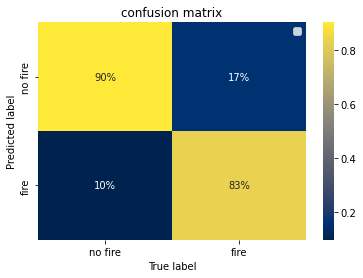

## Part III: Making the Susceptibility Map

**Q7) Using all the classifiers you trained that have a `predict_proba` method, predict the probability of a wildfire over the entire dataset.**

Hint: `predict_proba` will give you the probability of both the presence and absence of a wildfire, so you will have to select the right probability. 

In [102]:
# Predict the probability of a wildfire or not on the *entire* dataset
pr_rnd=rnd_cls.predict_proba(inputs)
pr_ext=ext_cls.predict_proba(inputs)

In [106]:
rnd_cls.classes_

array([0., 1.])

In [114]:
# Extract the probability of a wildfire 
# happening over the entire period of the dataset
# for each instance
wf_rnd = pr_rnd[:,1]
wf_ext = pr_ext[:,1]

In [141]:
print(pr_rnd)

[[0.82 0.18]
 [0.86 0.14]
 [0.65 0.35]
 ...
 [1.   0.  ]
 [0.94 0.06]
 [0.98 0.02]]


**Q8) Make the susceptibility map 🔥**

Hint 1: The `x` and `y` coordinates for the map can be extracted from the `variables` dataset.

Hint 2: You can simply [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) `x` versus `y`, and color the dots according to their probabilities (`c`=probability of a wildfire) to get the susceptibility map.

In [108]:
# Extract x and y
x = variables[['x']]
y = variables[['y']]

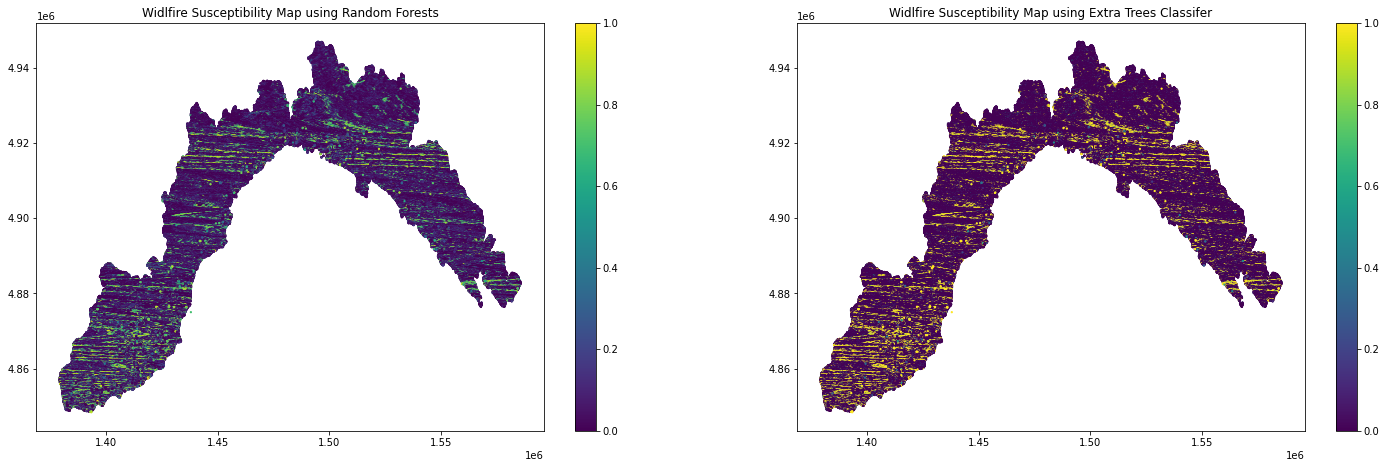

In [140]:
# Scatter x vs y and color the dots with the predicted probability
# to make the susceptibility map 
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7.5))
p1 = ax1.scatter(x, y, s = 1.5, c=wf_rnd, cmap='viridis') 
ax1.set_title('Widlfire Susceptibility Map using Random Forests')
f.colorbar(p1, ax = ax1)
ax2.scatter(x, y, s = 1.5, c=wf_ext, cmap='viridis')
p2 = ax2.set_title('Widlfire Susceptibility Map using Extra Trees Classifer')
f.colorbar(p1, ax = ax2)

You should get a susceptibility map that looks like the one below. Does your susceptibility map depend on the classifier & the inputs you chose? Which map would you trust most?

In [143]:
# MY MAPS LOOK VERY MUCH DIFFRENT FROM THE MAP BELOW AND THERE IS APPARENTLY A HORIZONTAL CORRELATION BETWEEN THE DATA! i THINK THE REASON MIGHT RELY IN ONE OF THE FACTS BELOW:
# 1. THE HYPERPARAMETERS ARE NOT TUNED.
# 2. THE INPUT SELECTION HAVE NOT BEEN OPTIMIZED.
# 3. OR THERE IS PROBLEM I CANNOT FIND! 

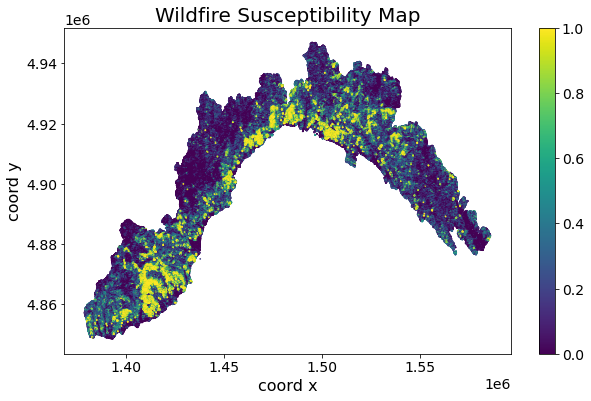

# Bonus Exercise 4: Exploring the Susceptibility Map's Sensitivity to Seasonality and Input Selection

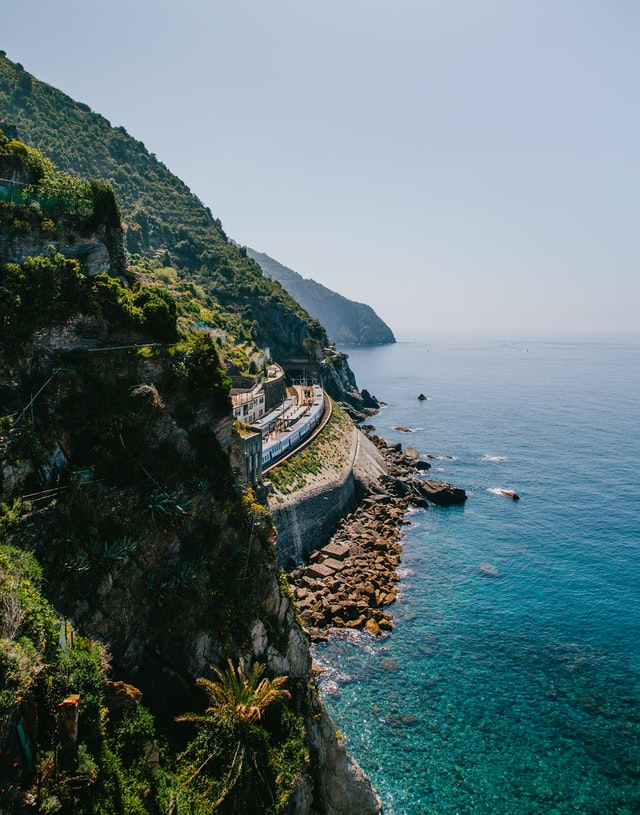

**Caption:** The Liguria region (Cinque Terre), after you save it from raging wildfires using machine learning ✌ 

## Part I: Seasonality

**Q1) Using the `season` column of `wildfires`, separate your data into two seasonal datasets (1=Winter, 2=Summer).**

Hint: When splitting your `inputs` into two seasonal datasets, keep in mind that `temp_1` and `prec_1` are the climatological mean temperatures and precipitation during winter, while `temp_2` and `prec_2` are the climatological mean temperature and precipitation during summer.  

In [ ]:
# Identify indices for which the wildfires occured during winter/summer

In [ ]:
# Use these indices to split your `inputs` and `outputs` datasets 
# into two seasonal datasets

In [ ]:
# Verify that for each season, the shape[0] of your
# `inputs` and `outputs` sets are the same

**Q2) Use these two seasonal datasets to make the Liguria winter and summer susceptibility maps using your best classifier(s). What do you notice?**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# So

In [ ]:
# Much

In [ ]:
# Recycling

In [ ]:
# Compare the winter and summer susceptibility maps

## Part II: Input Selection

The details of the susceptibility map may strongly depend on the inputs you chose from the `variables` dataset. Here, we explore two different ways of selecting inputs to make our susceptibility maps as robust as possible.

**Q3) Using your best classifier, identify the inputs contributing the most to your model's performance using [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html).**

Hint: You may use `scikit-learn`'s [`permutation_importance` function](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) using your best classifier as your `estimator`.

In [ ]:
# Import the necessary functions and classes

In [ ]:
# Calculate the permutation importance of each of your model's inputs

In [ ]:
# Display the result and identify the most important inputs

**Q4) Retrain the same type of classifier only using the inputs you identified as most important, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Lots

In [ ]:
# of

In [ ]:
# recycling

In [ ]:
# Make the new susceptibility map

Can you explain the differences in susceptibility maps based on the inputs' spatial distribution?

If the susceptibility map changed a lot, our best classifier may initially have learned spurious correlations. This would have affected our permutation feature importance analysis, and motivates re-selecting our inputs from scratch! 🔨

**Q5) Use the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to select the most important inputs. Select as few as possible!**

Hint: Track how the score improves as you add more and more inputs via `n_features_to_select`, and stop when it's "good enough".

In [ ]:
# Import the SequentialFeatureSelector

In [ ]:
# Add more and more inputs

In [ ]:
# How many inputs do you need to get a "good enough" score?

Which inputs have you identified as the most important? Are they the same as the ones you selected using permutation feature importance?

**Q6) Retrain the same type of classifier using as little inputs as possible, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Recycle your previous code here

In [ ]:
# and here

In [ ]:
# And remake the final susceptibility map

How does it compare to the authors' susceptibility map below?

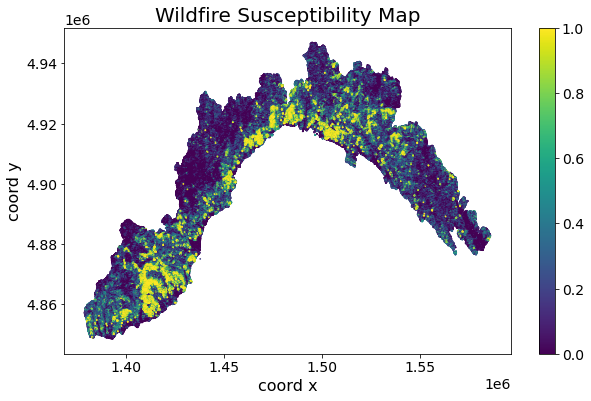